In [1]:
# import the necessary packages
import glob
import os
import tensorflow as tf
#import tflite_runtime.interpreter as tflite
import numpy as np
import argparse
import math
import imutils
import time
import cv2
import importlib.util
import urllib.request
import pathlib
import yaml
import decoders
from pathlib import Path
from PIL import Image
from threading import Thread


ModuleNotFoundError: No module named 'decoders'

In [31]:

def fourPointsTransform(frame, vertices):
    vertices = np.asarray(vertices)
    outputSize = (frame.shape[1], frame.shape[0])
    
    targetVertices = np.array([
        [0, outputSize[1] - 1],
        [0, 0],
        [outputSize[0] - 1, 0],
        [outputSize[0] - 1, outputSize[1] - 1]], dtype="float32")

    rotationMatrix = cv2.getPerspectiveTransform(vertices, targetVertices)
    result = cv2.warpPerspective(frame, rotationMatrix, outputSize)
    result = cv2.resize(result,(128, 32))
    return result

def cropImage(image, vertices):
    vertices = np.asarray(vertices)
    x_start = int(vertices[1][0])
    y_start = int(vertices[1][1])
    x_end = int(vertices[3][0])
    y_end = int(vertices[3][1])
    crop_img = image[y_start:y_end , x_start:x_end]
    crop_img = cv2.resize(crop_img,(128, 32))
    return crop_img

def decodeBoundingBoxes(scores, geometry, scoreThresh):
    detections = []
    confidences = []

    ############ CHECK DIMENSIONS AND SHAPES OF geometry AND scores ############
    assert len(scores.shape) == 4, "Incorrect dimensions of scores"
    assert len(geometry.shape) == 4, "Incorrect dimensions of geometry"
    assert scores.shape[0] == 1, "Invalid dimensions of scores"
    assert geometry.shape[0] == 1, "Invalid dimensions of geometry"
    assert scores.shape[1] == 1, "Invalid dimensions of scores"
    assert geometry.shape[1] == 5, "Invalid dimensions of geometry"
    assert scores.shape[2] == geometry.shape[2], "Invalid dimensions of scores and geometry"
    assert scores.shape[3] == geometry.shape[3], "Invalid dimensions of scores and geometry"
    height = scores.shape[2]
    width = scores.shape[3]
    for y in range(0, height):

        # Extract data from scores
        scoresData = scores[0][0][y]
        x0_data = geometry[0][0][y]
        x1_data = geometry[0][1][y]
        x2_data = geometry[0][2][y]
        x3_data = geometry[0][3][y]
        anglesData = geometry[0][4][y]
        for x in range(0, width):
            score = scoresData[x]

            # If score is lower than threshold score, move to next x
            if (score < scoreThresh):
                continue

            # Calculate offset
            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]

            # Calculate cos and sin of angle
            cosA = math.cos(angle)
            sinA = math.sin(angle)
            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]

            # Calculate offset
            offset = ([offsetX + cosA * x1_data[x] + sinA * x2_data[x], offsetY - sinA * x1_data[x] + cosA * x2_data[x]])

            # Find points for rectangle
            p1 = (-sinA * h + offset[0], -cosA * h + offset[1])
            p3 = (-cosA * w + offset[0], sinA * w + offset[1])
            center = (0.5 * (p1[0] + p3[0]), 0.5 * (p1[1] + p3[1]))
            detections.append((center, (w, h), -1 * angle * 180.0 / math.pi))
            confidences.append(float(score))

    # Return detections and confidences
    return [detections, confidences]

def convert_to_tensor(arr):
  tensor = tf.convert_to_tensor(arr, dtype=tf.uint8)
  return tensor


mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
mean_tensor = convert_to_tensor(mean)

def preprocess_image(image, mean):
    image = image.astype(np.uint8)
    return image


def run_ocr_inference(image, model_path):
    # initialize the TFLite interpreter
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    image = np.expand_dims(image, 0)
    interpreter.set_tensor(input_details[0]['index'], image)
    
    interpreter.invoke()
    output = interpreter.tensor(interpreter.get_output_details()[0]['index'])()
    #output = convert_to_tensor(output)
    return output


confThreshold = 0.5
nmsThreshold = 0.4
decoder = decoders.CTCGreedyDecoder('table.txt')
padding = 0

# Import TensorFlow libraries
# If tflite_runtime is installed, import interpreter from tflite_runtime, else import from regular tensorflow
# If using Coral Edge TPU, import the load_delegate library

from tensorflow.lite.python.interpreter import Interpreter  
# Get path to current working directory
CWD_PATH = os.getcwd()
# Path to .tflite file, which contains the model that is used for object detection
PATH_TO_CKPT = 'weightes/east_model_int8.tflite'
PATH_TO_OCR = 'weightes/CRNN_float16.tflite'


# initialize the original frame dimensions, new frame dimensions,
# and ratio between the dimensions
image_path = "images/coffee.jpg"
vs = None
orig = None
orig = None
indices = None
boxes = None
vertices = None

(newW, newH) = (320, 320)
(rW, rH) = (None, None)
frame = cv2.imread(image_path)
frame = cv2.resize(frame, (400,400))    
orig = frame.copy()
clear_orig = orig.copy()
(H, W) = frame.shape[:2]
rW = W / float(newW)
rH = H / float(newH)
interpreter = tf.lite.Interpreter(PATH_TO_CKPT)
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()

# perform inference and parse the outputs
frame = cv2.resize(frame, (newW, newH))
frame = preprocess_image(frame, mean)
frame = np.expand_dims(frame, 0)
interpreter.set_tensor(input_details[0]['index'], frame)
interpreter.invoke()

scores = interpreter.tensor(
    interpreter.get_output_details()[0]['index'])()
geometry = interpreter.tensor(
    interpreter.get_output_details()[1]['index'])()
scores = np.transpose(scores, (0, 3, 1, 2)) 
geometry = np.transpose(geometry, (0, 3, 1, 2))
[boxes, confidences] = decodeBoundingBoxes(scores, geometry, confThreshold)

indices = cv2.dnn.NMSBoxesRotated(boxes, confidences, confThreshold, nmsThreshold)

for i in indices:
    
    # get 4 corners of the rotated rect
    vertices = cv2.boxPoints(boxes[i])
    
    # scale the bounding box coordinates based on the respective ratios
    for j in range(4):
        vertices[j][0] *= rW
        vertices[j][1] *= rH
    #Adjust bounding box size for model int8

    start_point = (tuple(vertices[1]))
    end_point = (tuple(vertices[3]))
    

    interpreter_ocr = tf.lite.Interpreter(PATH_TO_OCR)
        
    input_details_ocr = interpreter_ocr.get_input_details()
    interpreter_ocr.allocate_tensors()
    
    cropped = fourPointsTransform(clear_orig, vertices)
    cropped = np.float32(cropped)   
    outputs = run_ocr_inference(cropped, PATH_TO_OCR)
    
    if not isinstance(outputs, tuple):
        outputs = decoder(outputs)
    text = str(outputs[0].numpy())
    text = text[2:-1]
    print(text)
    print(vertices)
    cv2.putText(orig, text, (int(vertices[0][1]), int(vertices[1][1])), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 255, 0), 2)
    cv2.rectangle(orig, start_point, end_point, (0, 0, 255), 2)
        
cv2.imshow("Text Detection", orig)
cv2.waitKey(0)



coff
[[113.75  91.25]
 [113.75  65.  ]
 [228.75  65.  ]
 [228.75  91.25]]


error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'rec'. Expected sequence length 4, got 2
>  - Can't parse 'rec'. Expected sequence length 4, got 2


In [40]:
start_point
end_point

(228.75, 91.25)

In [32]:
start_point = (min(vertices[:, 0]), min(vertices[:, 1]))  # Min x and y
end_point = (max(vertices[:, 0]), max(vertices[:, 1]))  # Max x and y

# Ensure points are tuples of integers
start_point = tuple(map(int, start_point))
end_point = tuple(map(int, end_point))

cv2.rectangle(orig, start_point, end_point, (0, 0, 255), 2)
plt.show(orig)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [30]:
def fourPointsTransform(frame, vertices):
    vertices = np.asarray(vertices, dtype="float32")
    outputSize = (frame.shape[1], frame.shape[0])
    
    targetVertices = np.array([
        [0, outputSize[1] - 1],
        [0, 0],
        [outputSize[0] - 1, 0],
        [outputSize[0] - 1, outputSize[1] - 1]], dtype="float32")

    rotationMatrix = cv2.getPerspectiveTransform(vertices, targetVertices)
    result = cv2.warpPerspective(frame, rotationMatrix, outputSize)
    result = cv2.resize(result, (128, 32))
    return result

def decodeBoundingBoxes(scores, geometry, scoreThresh):
    detections = []
    confidences = []
    
    assert len(scores.shape) == 4, "Incorrect dimensions of scores"
    assert len(geometry.shape) == 4, "Incorrect dimensions of geometry"
    assert scores.shape[0] == 1, "Invalid dimensions of scores"
    assert geometry.shape[0] == 1, "Invalid dimensions of geometry"
    assert scores.shape[1] == 1, "Invalid dimensions of scores"
    assert geometry.shape[1] == 5, "Invalid dimensions of geometry"
    assert scores.shape[2] == geometry.shape[2], "Invalid dimensions of scores and geometry"
    assert scores.shape[3] == geometry.shape[3], "Invalid dimensions of scores and geometry"
    
    height = scores.shape[2]
    width = scores.shape[3]
    for y in range(height):
        scoresData = scores[0][0][y]
        x0_data = geometry[0][0][y]
        x1_data = geometry[0][1][y]
        x2_data = geometry[0][2][y]
        x3_data = geometry[0][3][y]
        anglesData = geometry[0][4][y]

        for x in range(width):
            score = scoresData[x]
            if score < scoreThresh:
                continue
            
            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]
            cosA = math.cos(angle)
            sinA = math.sin(angle)
            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]

            offset = (offsetX + cosA * x1_data[x] + sinA * x2_data[x],
                      offsetY - sinA * x1_data[x] + cosA * x2_data[x])

            p1 = (-sinA * h + offset[0], -cosA * h + offset[1])
            p3 = (-cosA * w + offset[0], sinA * w + offset[1])
            center = (0.5 * (p1[0] + p3[0]), 0.5 * (p1[1] + p3[1]))

            detections.append((center, (w, h), -1 * angle * 180.0 / math.pi))
            confidences.append(float(score))

    return detections, confidences

def preprocess_image(image, mean):
    image = image.astype(np.uint8)
    image -= mean
    return image

def run_ocr_inference(image, model_path):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    image = np.expand_dims(image, 0)
    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()

    output = interpreter.get_tensor(output_details[0]['index'])
    return output

# Assuming you have a decoder function for your OCR model's output
def decode_output(output):
    # Your decoder logic here
    text = "Decoded Text"  # Placeholder for actual decoding logic
    return text

# Main Script
CWD_PATH = os.getcwd()
PATH_TO_CKPT = os.path.join(CWD_PATH, 'weightes/east_model_int8.tflite')
PATH_TO_OCR = os.path.join(CWD_PATH, 'weightes/CRNN_float16.tflite')
image_path = os.path.join(CWD_PATH, "images/coffee.jpg")

mean = np.array([123.68, 116.779, 103.939][::-1], dtype= np.uint8)
confThreshold = 0.5
nmsThreshold = 0.4

frame = cv2.imread(image_path)
orig = frame.copy()
clear_orig = orig.copy()
(H, W) = frame.shape[:2]

(newW, newH) = (320, 320)
rW = W / float(newW)
rH = H / float(newH)

frame = cv2.resize(frame, (newW, newH))
frame = preprocess_image(frame, mean)

interpreter = tf.lite.Interpreter(PATH_TO_CKPT)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
interpreter.set_tensor(input_details[0]['index'], np.expand_dims(frame, 0))
interpreter.invoke()

scores = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
geometry = interpreter.get_tensor(interpreter.get_output_details()[1]['index'])
scores = np.transpose(scores, (0, 3, 1, 2))
geometry = np.transpose(geometry, (0, 3, 1, 2))

boxes, confidences = decodeBoundingBoxes(scores, geometry, confThreshold)
indices = cv2.dnn.NMSBoxesRotated(boxes, confidences, confThreshold, nmsThreshold)

interpreter_ocr = tf.lite.Interpreter(PATH_TO_OCR)
interpreter_ocr.allocate_tensors()

for i in indices:
    vertices = cv2.boxPoints(boxes[i[0]])
    for j in range(4):
        vertices[j][0] *= rW
        vertices[j][1] *= rH

    cropped = fourPointsTransform(clear_orig, vertices)
    outputs = run_ocr_inference(cropped, PATH_TO_OCR)
    text = decode_output(outputs)
    
    cv2.putText(orig, text, (int(vertices[1][0]), int(vertices[1][1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.rectangle(orig, tuple(vertices[1]), tuple(vertices[3]), (0, 0, 255), 2)

plt.imshow(orig)

IndexError: invalid index to scalar variable.

In [46]:
def preprocess_image(image_path):
    # load the input image and grab the image dimensions
    image = cv2.imread(image_path)
    orig = image.copy()
    (H, W) = image.shape[:2]
    
    # set the new width and height and then determine the ratio in change
    # for both the width and height
    (newW, newH) = (320, 320)
    rW = W / float(newW)
    rH = H / float(newH)

    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    # convert the image to a floating point data type and perform mean
    # subtraction
    image = image.astype("float32")
    mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
    image -= mean
    image = np.expand_dims(image, 0)

    return image, orig, rW, rH

In [47]:
image, orig, rW, rH = preprocess_image("images/stop-sign.jpg")
scores, geometry = perform_inference(tflite_path= "weightes/east_model_int8.tflite",
                                     preprocessed_image=image)


Integer quantization!
Inference took: 0.14999890327453613 seconds


In [48]:
def perform_inference(tflite_path, preprocessed_image):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    input_details = interpreter.get_input_details()
    
    if input_details[0]["dtype"]==np.uint8:
        print("Integer quantization!")
        input_scale, input_zero_point = input_details[0]["quantization"]
        preprocessed_image = preprocessed_image / input_scale + input_zero_point
    preprocessed_image = preprocessed_image.astype(input_details[0]["dtype"])
    interpreter.allocate_tensors()
    interpreter.set_tensor(input_details[0]['index'], preprocessed_image)

    start = time.time()
    interpreter.invoke()
    print(f"Inference took: {time.time()-start} seconds")

    scores = interpreter.tensor(
        interpreter.get_output_details()[0]['index'])()
    geometry = interpreter.tensor(
        interpreter.get_output_details()[1]['index'])()

    return scores, geometry

In [49]:

scores, geometry = perform_inference(tflite_path= "weightes/east_model_int8.tflite",
                                     preprocessed_image=image)

Integer quantization!
Inference took: 0.14800143241882324 seconds


In [50]:
# We need to have this shape:  (1, 1, 80, 80) (1, 5, 80, 80) 
scores.shape, geometry.shape 

((1, 80, 80, 1), (1, 80, 80, 5))

In [51]:
scores = np.transpose(scores, (0, 3, 1, 2)) 
geometry = np.transpose(geometry, (0, 3, 1, 2))
scores.shape, geometry.shape 

((1, 1, 80, 80), (1, 5, 80, 80))

In [52]:
def post_process(score, geo, ratioW, ratioH, original):
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = score.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = score[0, 0, y]
        xData0 = geo[0, 0, y]
        xData1 = geo[0, 1, y]
        xData2 = geo[0, 2, y]
        xData3 = geo[0, 3, y]
        anglesData = geo[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < 0.5:
                continue

            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * ratioW)
        startY = int(startY * ratioH)
        endX = int(endX * ratioW)
        endY = int(endY * ratioH)

        # draw the bounding box on the image
        cv2.rectangle(original, (startX, startY), (endX, endY), (0, 255, 0), 2)

    # show the output image

    plt.imshow(original)

    
    plt.show()

In [53]:
from imutils.object_detection import non_max_suppression
import matplotlib.pyplot as plt

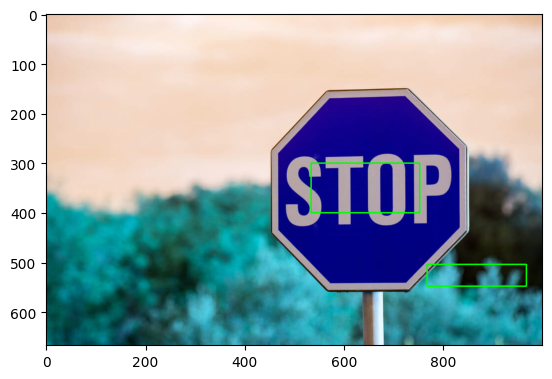

In [54]:
original = cv2.imread("images/stop-sign.jpg")
post_process(scores, geometry, rW, rH, original)

Integer quantization!
Inference took: 0.15199756622314453 seconds


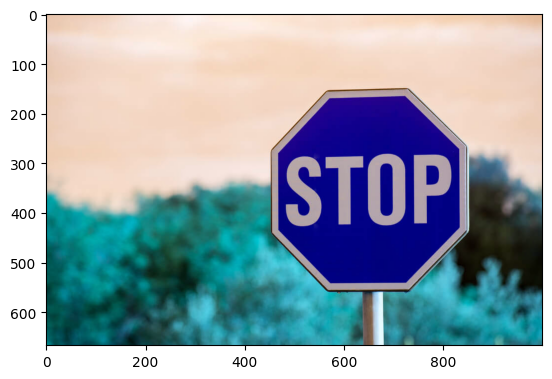